In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
import string
import pickle
import emoji
import scipy.stats as ss
import sklearn
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report,plot_confusion_matrix
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.utils.validation import check_is_fitted
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
import nltk
nltk.download('omw-1.4')
import keras
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.models import load_model
from keras.utils import to_categorical, pad_sequences
from textblob import TextBlob
import langid
from langdetect import detect

%matplotlib inline

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Kamen\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
#Convert emojis to words 
with open('Emoji_Dict.p', 'rb') as fp:
        Emoji_Dict = pickle.load(fp)
Emoji_Dict = {v: k for k, v in Emoji_Dict.items()}

def convert_emojis_to_word(mess):
    for emot in Emoji_Dict:
        mess = re.sub(r'('+emot+')', "_".join(Emoji_Dict[emot].replace(",","").replace(":","").split()), mess)
    return mess

str_punc = string.punctuation.replace(',', '').replace("'",'')

def clean(text):
    global str_punc
    text = convert_emojis_to_word(text)
    text = re.sub(r'[^a-zA-Z ]', '', text)
    text = text.lower()
    return text 
    
#def text_process(mess):
    
#    #Convert emojis to words
#    mess = convert_emojis_to_word(mess)
#    mess = mess.lower() # lowercase text
#    mess = REPLACE_BY_SPACE_RE.sub('', mess) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
#    mess = BAD_SYMBOLS_RE.sub('', mess)

    # Check characters to see if they are in punctuation
#    nopunc = [char for char in mess if char not in string.punctuation]
    
    # Join the characters again to form the string.
#    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
#    stop = ' '.join([word for word in nopunc.split() if word.lower() not in stopwords.words('english')])

#    return stop

In [3]:
df_tr_2 = pd.read_csv('emotion-labels-train.csv')
df_te_2 = pd.read_csv('emotion-labels-test.csv')
df_v_2 = pd.read_csv("emotion-labels-val.csv")

In [4]:
df_te_2

,text,label
0,You must be knowing #blithe means (adj.) Happ...,joy
1,Old saying 'A #smile shared is one gained for ...,joy
2,Bridget Jones' Baby was bloody hilarious 😅 #Br...,joy
3,@Elaminova sparkling water makes your life spa...,joy
4,I'm tired of everybody telling me to chill out...,joy
...,...,...
3137,Why does Candice constantly pout #GBBO 💄😒,sadness
3138,"@redBus_in #unhappy with #redbus CC, when I ta...",sadness
3139,"@AceOperative789 no pull him afew weeks ago, s...",sadness
3140,I'm buying art supplies and I'm debating how s...,sadness


In [5]:
#A NEW DAY, NEW OPPORTUNITY
df_tr = pd.read_csv('train.txt',sep=';')
df_tr.rename({'i didnt feel humiliated':'text','sadness':'label'}, axis = 1, inplace=True)
df_v = pd.read_csv('val.txt', sep=';')
df_v.rename({'im feeling quite sad and sorry for myself but ill snap out of it soon':'text','sadness':'label'}, axis = 1, inplace=True)
df_te = pd.read_csv('test.csv', sep=';')
df_te.rename({'im feeling rather rotten so im not very ambitious right now':'text','sadness':'label'}, axis = 1, inplace=True)

In [6]:
df_tr = pd.concat([df_tr,df_tr_2])
df_te = pd.concat([df_te, df_te_2])
df_v = pd.concat([df_v, df_v_2])

In [7]:
print(len(df_tr))
print(len(df_te))
print(len(df_v))

19612
5141
2346


In [8]:
print('Training data length: ', len(df_tr))
print('Validation data length: ', len(df_v))
print('Testing data length: ', len(df_te))

Training data length:  19612
Validation data length:  2346
Testing data length:  5141


In [9]:
duplicateRows = df_te[df_te['text'].duplicated()]
duplicateRows

,text,label
1474,@iTriborg — make him feel vigorous. 'Fine. You...,fear
2463,"Not by wrath does one kill, but by laughter. ...",anger
2474,@spamvicious I've just found out it's Candice ...,sadness
2489,Time for some despair #SDR3 #despair #fuckthis...,sadness
2500,"@NikeSupport ok, thats it. After 2 weeks not b...",sadness
2513,@ThomasHCrown @laurakfillault As a historic ev...,sadness
2533,@mar_de_palabras But I do think we need to exp...,sadness
2570,Migraine hangover all day. Stood up to do dish...,sadness
2594,I am going to make it my life's mission to dis...,sadness
2604,@MarianKeyes the pout tips me over the edge. I...,sadness


In [10]:
#LSTM
from keras.utils.data_utils import pad_sequences
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Embedding, Bidirectional

In [11]:
dfs = [df_tr, df_v, df_te]
for df in dfs:
    print('Processing text data')
    df['to_check'] = df['text'].apply(clean)
    print('Encoding y values')
    df['label']=df['label'].replace({'joy':0,'anger':1,'love':2,'sadness':3,'fear':4,'surprise':5})
    print('\n')

Processing text data
Encoding y values


Processing text data
Encoding y values


Processing text data
Encoding y values




In [12]:
df_te.head()

,text,label,to_check
0,im updating my blog because i feel shitty,3,im updating my blog because i feel shitty
1,i never make her separate from me because i do...,3,i never make her separate from me because i do...
2,i left with my bouquet of red and yellow tulip...,0,i left with my bouquet of red and yellow tulip...
3,i was feeling a little vain when i did this one,3,i was feeling a little vain when i did this one
4,i cant walk into a shop anywhere where i do no...,4,i cant walk into a shop anywhere where i do no...


In [13]:
X_tr = df_tr['to_check'].values
y_tr = df_tr['label'].values
X_v = df_v['to_check'].values
y_v = df_v['label'].values
X_te = df_te['to_check'].values
y_te = df_te['label'].values
#X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.1, random_state = 42)
print('Training data shape: ',X_tr.shape,y_tr.shape)
print('Validation data shape: ',X_v.shape,y_v.shape)
print('test data shape: ',X_te.shape,y_te.shape)

Training data shape:  (19612,) (19612,)
Validation data shape:  (2346,) (2346,)
test data shape:  (5141,) (5141,)


In [14]:
#Prepare parameters
n_words = 20000 # cut texts after this 
maxlen = 80
batch_size = 128 

In [15]:
tokenizer = Tokenizer(num_words=n_words, lower=True)
tokenizer.fit_on_texts(X_tr)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 20984 unique tokens.


In [16]:
X_tr = tokenizer.texts_to_sequences(X_tr)
X_tr = pad_sequences(X_tr, maxlen=maxlen)
print('Shape of data tensor:', X_tr.shape)

Shape of data tensor: (19612, 80)


In [17]:
#One Hot Encoding Training data
y_tr=to_categorical(y_tr)
y_tr

array([[0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.]], dtype=float32)

In [18]:
#X_test
X_v = tokenizer.texts_to_sequences(X_v)
X_v = pad_sequences(X_v, maxlen=maxlen)

In [19]:
#One Hot Encode validation data
y_v = to_categorical(y_v)

In [26]:
#Bidirectional LSTM Model creation
model=Sequential()
model.add(Embedding(21000,64,input_length=80))
model.add(Dropout(0.6))
model.add(Bidirectional(LSTM(80,return_sequences=True)))
model.add(Bidirectional(LSTM(160)))
model.add(Dense(6,activation='softmax'))
print(model.summary())
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 80, 64)            1344000   
                                                                 
 dropout_2 (Dropout)         (None, 80, 64)            0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 80, 160)          92800     
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 320)              410880    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 6)                 1926      
                                                                 
Total params: 1,849,606
Trainable params: 1,849,606
No

In [29]:
hist=model.fit(X_tr,y_tr,epochs=10,validation_data=(X_v,y_v))

Epoch 1/10
613/613 [==============================] - 816s 1s/step - loss: 0.0804 - accuracy: 0.9684 - val_loss: 0.2795 - val_accuracy: 0.9113
Epoch 2/10
613/613 [==============================] - 890s 1s/step - loss: 0.0726 - accuracy: 0.9729 - val_loss: 0.2909 - val_accuracy: 0.9096
Epoch 3/10
613/613 [==============================] - 979s 2s/step - loss: 0.0641 - accuracy: 0.9747 - val_loss: 0.2871 - val_accuracy: 0.9096
Epoch 4/10
613/613 [==============================] - 938s 2s/step - loss: 0.0580 - accuracy: 0.9768 - val_loss: 0.3015 - val_accuracy: 0.9054
Epoch 5/10
613/613 [==============================] - 1005s 2s/step - loss: 0.0550 - accuracy: 0.9777 - val_loss: 0.3012 - val_accuracy: 0.9088
Epoch 6/10
613/613 [==============================] - 863s 1s/step - loss: 0.0518 - accuracy: 0.9785 - val_loss: 0.3082 - val_accuracy: 0.9084
Epoch 7/10
613/613 [==============================] - 948s 2s/step - loss: 0.0503 - accuracy: 0.9804 - val_loss: 0.3034 - val_accuracy: 0.910

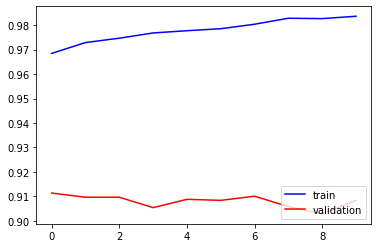

In [30]:
"""
IMPORTANT:
Training data has to come from train.txt
Validation data has to come from val.txt
Test data has to from test.txt
"""
import matplotlib.pyplot as plt 
%matplotlib inline
plt.plot(hist.history['accuracy'],c='b',label='train')
plt.plot(hist.history['val_accuracy'],c='r',label='validation')
plt.legend(loc='lower right')
plt.show()

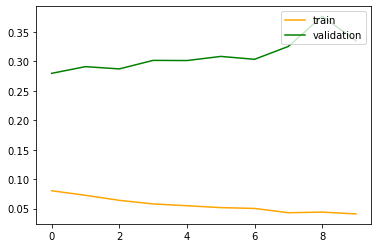

In [31]:
plt.plot(hist.history['loss'],c='orange',label='train')
plt.plot(hist.history['val_loss'],c='g',label='validation')
plt.legend(loc='upper right')
plt.show()

In [32]:
#Let's test the model
X_te = tokenizer.texts_to_sequences(X_te)
X_te = pad_sequences(X_te, maxlen=maxlen)

In [33]:
y_te = to_categorical(y_te)

In [34]:
X_te.shape

(5141, 80)

In [35]:
model.evaluate(X_te,y_te)

161/161 [==============================] - 15s 93ms/step - loss: 0.7586 - accuracy: 0.8228


[0.7586392164230347, 0.8227971196174622]

In [36]:
y_pred=model.predict(X_te)

161/161 [==============================] - 17s 95ms/step


In [37]:
y_test_arg=np.argmax(y_te,axis=1)
Y_pred = np.argmax(model.predict(X_te),axis=1)
print('Confusion Matrix')
print(confusion_matrix(y_test_arg, Y_pred))

161/161 [==============================] - 19s 117ms/step
Confusion Matrix
[[1289   27   15   34   39    5]
 [  54  861    2   62   56    0]
 [  31    1  126    1    0    0]
 [  38   70    4 1070   71    0]
 [ 116   81    5  169  834   14]
 [   6    1    0    0    9   50]]


In [38]:
#classification report
print(classification_report(y_test_arg, Y_pred))

              precision    recall  f1-score   support

           0       0.84      0.91      0.88      1409
           1       0.83      0.83      0.83      1035
           2       0.83      0.79      0.81       159
           3       0.80      0.85      0.83      1253
           4       0.83      0.68      0.75      1219
           5       0.72      0.76      0.74        66

    accuracy                           0.82      5141
   macro avg       0.81      0.81      0.81      5141
weighted avg       0.82      0.82      0.82      5141



In [39]:
model.save('LSTM_mod3.h5')

In [40]:
#Define function for new input
#Add textBlob to have all languages included
#Prepare parameters
n_words = 20000 # cut texts after this 
maxlen = 80
batch_size = 128
tokenizer = Tokenizer(num_words=n_words, lower=True)
def dico(arg): 
    val_dict = {'joy':0,
                'anger':1,
                'love':2,
                'sadness':3,
                'fear':4,
                'surprise':5}
    for key, val in val_dict.items():
        if val == arg: 
            return key

def predict_new_data(text):

    #Handle data that is not english
    text = TextBlob(text).correct()
    text = str(text)
    lang_detect = str(langid.classify(text))[2:4]
    print(lang_detect)
    if lang_detect != "en": 
        text = TextBlob(text).translate(from_lang = lang_detect, to = "en")
        print(text)
        
    text = str(text)
    #Prepare data to feed the model
    text = clean(text)
    sen_list = []
    sen_list.append(text) 
    tokenizer.fit_on_texts(sen_list)
    text_seq = tokenizer.texts_to_sequences(sen_list)
    text_pad = pad_sequences(text_seq, maxlen=maxlen)
    model = load_model('LSTM_mod3.h5')
    return dico(np.argmax(model.predict(text_pad)))

In [42]:
string = "What is this bullshit"
print("What the human said: ", string)
print("Predicted emotion by the AI: ", predict_new_data(string))

What the human said:  What is this bullshit
en
1/1 [==============================] - 6s 6s/step
Predicted emotion by the AI:  joy
